# Corrective RAG (CRAG)

[Corrective-RAG (CRAG)](https://arxiv.org/abs/2401.15884) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents. 

The paper follows this general flow:

* If at least one document exceeds the threshold for `relevance`, then it proceeds to generation
* If all documents fall below the `relevance` threshold or if the grader is unsure, then it uses web search to supplement retrieval
* Before generation, it performs knowledge refinement of the search or retrieved documents
* This partitions the document into `knowledge strips`
* It grades each strip, and filters out irrelevant ones

We will implement some of these ideas from scratch using [LangGraph](https://langchain-ai.github.io/langgraph/):

* If *any* documents are irrelevant, we'll supplement retrieval with web search. 
* We'll skip the knowledge refinement, but this can be added back as a node if desired. 
* We'll use [Tavily Search](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

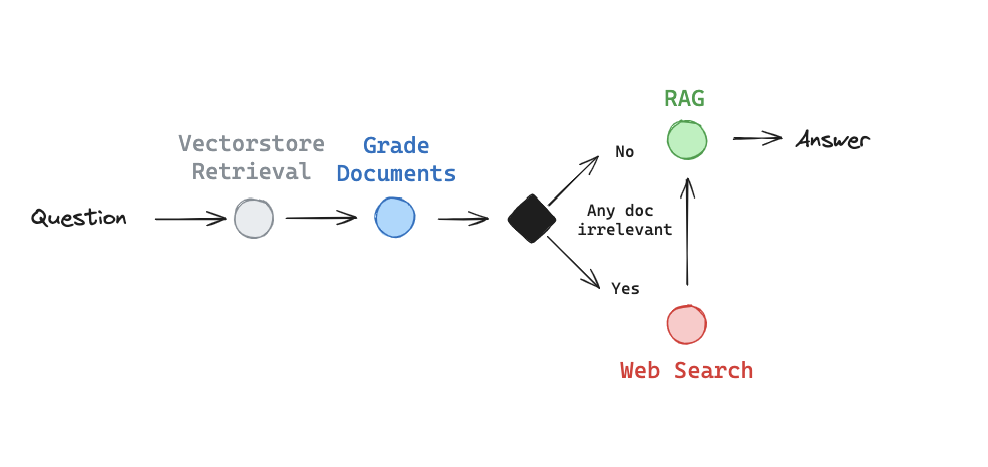

### Environment

We'll use [Tavily](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

We'll use a Chroma vectorstore with HuggingFaceBgeEmbeddings.

We'll use [LangSmith Doc](https://docs.smith.langchain.com/) for [tracing and evaluation](https://smith.langchain.com/).

In [1]:
# %%capture --no-stderr
# %pip install -U langchain_community tiktoken langchainhub scikit-learn langchain langgraph tavily-python  nomic[local] langchain-nomic langchain_openai

In [2]:
# Search
import os
from dotenv import load_dotenv
load_dotenv(override=True)

os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_ENDPOINT']="https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY']=os.getenv("LANGCHAIN_API_KEY", None)
os.environ['LANGCHAIN_PROJECT']="corrective_rag_bam"

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY", None)

### LLM


In [3]:
import warnings
warnings.filterwarnings("ignore")

# from dotenv import load_dotenv
# load_dotenv(override=True)

from genai import Client, Credentials
from genai.extensions.langchain import LangChainInterface
from genai.schema import (
    DecodingMethod,
    TextGenerationParameters,
)
# from langchain_ibm import WatsonxLLM
# from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams


def bam_model(model_id='meta-llama/llama-3-8b-instruct', decoding_method='greedy', max_new_tokens=1000, 
              min_new_tokens=1, temperature=0.5, top_k=50, top_p=1, repetition_penalty=1):

    if decoding_method == 'greedy':
        decoding_method = DecodingMethod.GREEDY
        parameters=TextGenerationParameters(
            decoding_method=decoding_method,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            repetition_penalty=repetition_penalty
        )
    else:
        decoding_method = DecodingMethod.SAMPLE
        parameters=TextGenerationParameters(
            decoding_method=decoding_method,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=repetition_penalty
        )

    llm = LangChainInterface(
        model_id=model_id,
        client=Client(credentials=Credentials.from_env()),
        parameters=parameters,
    )

    return llm
'''
# def watsonx_model(model_id="mistralai/mixtral-8x7b-instruct-v01", decoding_method='greedy', max_new_tokens=1000, 
#                   min_new_tokens=1, temperature=0.5, top_k=50, top_p=1, repetition_penalty=1):
#     params = {
#         GenParams.DECODING_METHOD: decoding_method,
#         GenParams.MIN_NEW_TOKENS: min_new_tokens,
#         GenParams.MAX_NEW_TOKENS: max_new_tokens,
#         GenParams.RANDOM_SEED: 42,
#         GenParams.TEMPERATURE: temperature,
#         GenParams.TOP_K: top_k,
#         GenParams.TOP_P: top_p,
#         GenParams.REPETITION_PENALTY: repetition_penalty
#     }
#     ibm_cloud_url = os.getenv("IBM_CLOUD_URL", None)
#     project_id = os.getenv("PROJECT_ID", None)
#     api_key = os.getenv("API_KEY")
#     watsonx_llm = WatsonxLLM(
#         model_id=model_id,
#         url=ibm_cloud_url,
#         apikey=api_key,
#         project_id=project_id,
#         params=params,
#     )
#     return watsonx_llm
'''
# prompt = "Tell me about IBM."
# print(f"Prompt: {prompt}")

local_llm = bam_model()
# print(local_llm.invoke(prompt))


# local_llm = "llama3"
model_tested = "meta-llama/llama-3-8b-instruct"
metadata = f"CRAG, {model_tested}"

### Index

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings, HuggingFaceBgeEmbeddings

# Load
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=100
)
doc_splits = text_splitter.split_documents(docs_list)

# Embed and index
embedding = HuggingFaceBgeEmbeddings()

# Index
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embedding,
)
retriever = vectorstore.as_retriever()

### Tools

In [5]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = local_llm  #ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 1 or 0 score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "documents"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'score': 1}


In [6]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 

    Use three sentences maximum and keep the answer concise.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Documents: {documents} 
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
llm = local_llm #ChatOllama(model=local_llm, temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

 The agent memory is a long-term memory module that records a comprehensive list of agents' experience in natural language. It uses a retrieval model to surface the context to inform the agent's behavior, based on relevance, recency, and importance.


In [7]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

### Graph 

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

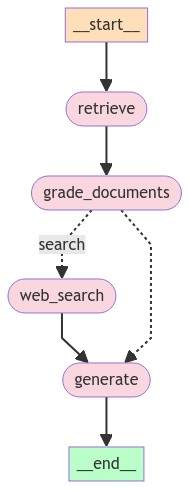

In [8]:
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        if grade == 1:
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
import uuid


def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "What are the types of agent memory?"}
response = predict_custom_agent_local_answer(example)
response

{'response': " The types of agent memory mentioned in the documents are: \n     - Memory stream: a long-term memory module that records a comprehensive list of agents' experience in natural language. \n     - Retrieval model: surfaces the context to inform the agent's behavior, according to relevance, recency, and importance. \n     - Reflection mechanism: synthesizes memories into higher-level inferences over time and guides the agent's future behavior. \n     - Short-term memory: stores information that the agent is currently aware of and needed to carry out complex cognitive tasks. \n     - Long-term memory: stores information for a remarkably long time, ranging from a few days to decades, with an essentially unlimited storage capacity.",
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'generate_answer']}

In [10]:
example = {"input": "What is the current medal tally of Paris Olympic 2024?"}
response = predict_custom_agent_local_answer(example)
response

{'response': " I don't have the current medal tally of Paris Olympic 2024 as the information provided is outdated. The documents only provide information up to the third day of competition, and the Olympics have not yet concluded.",
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

In [11]:
example = {"input": "What is the theory of relativity?"}
response = predict_custom_agent_local_answer(example)
response

{'response': ' The theory of relativity, developed by Albert Einstein, is a fundamental concept in modern physics that describes the nature of space and time. It consists of two main components: special relativity and general relativity. Special relativity reveals that the speed of light is a limit that can be approached but not reached by any material object, and it has led to other tantalizing outcomes, such as the "twin paradox." General relativity, on the other hand, is concerned with gravity, one of the fundamental forces in the universe, and it has led to a deeper understanding of the behavior of celestial bodies and the nature of black holes.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

## Evaluation

Now we've defined two different agent architectures that do roughly the same thing!

We can evaluate them. See our [conceptual guide](https://docs.smith.langchain.com/concepts/evaluation#agents) for context on agent evaluation.

### Response

First, we can assess how well [our agent performs on a set of question-answer pairs](https://docs.smith.langchain.com/tutorials/Developers/agents#response-evaluation).

We'll create a dataset and save it in LangSmith.

In [12]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    (
        "How does the ReAct agent use self-reflection? ",
        "ReAct integrates reasoning and acting, performing actions - such tools like Wikipedia search API - and then observing / reasoning about the tool outputs.",
    ),
    (
        "What are the types of biases that can arise with few-shot prompting?",
        "The biases that can arise with few-shot prompting include (1) Majority label bias, (2) Recency bias, and (3) Common token bias.",
    ),
    (
        "What are five types of adversarial attacks?",
        "Five types of adversarial attacks are (1) Token manipulation, (2) Gradient based attack, (3) Jailbreak prompting, (4) Human red-teaming, (5) Model red-teaming.",
    ),
    (
        "Who did the Chicago Bears draft first in the 2024 NFL draft”?",
        "The Chicago Bears drafted Caleb Williams first in the 2024 NFL draft.",
    ),
    (
        "Who won the 2024 NBA finals?", 
        "The Boston Celtics won the 2024 NBA finals"
    ),
]

# Save it
dataset_name = "Corrective RAG Agent Testing"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

Now, we'll use an `LLM as a grader` to compare both agent responses to our ground truth reference answer.

[Here](https://smith.langchain.com/hub/rlm/rag-answer-vs-reference) is the default prompt that we can use.

We'll use `llama3-8b` as our LLM grader.


In [13]:
from langchain import hub

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")


def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get the question, the ground truth reference answer, RAG chain answer prediction
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # Define an LLM grader
    llm = local_llm # ChatOpenAI(model="gpt-4o", temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]
    return {"key": "answer_v_reference_score", "score": score}

### Trajectory

Second, [we can assess the list of tool calls](https://docs.smith.langchain.com/tutorials/Developers/agents#trajectory) that each agent makes relative to expected trajectories.

This evaluates the specific reasoning traces taken by our agents!

In [14]:
from langsmith.schemas import Example, Run
os.environ['TOKENIZERS_PARALLELISM']='true'

# Reasoning traces that we expect the agents to take
expected_trajectory_1 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "web_search",
    "generate_answer",
]
expected_trajectory_2 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "generate_answer",
]

def check_trajectory_custom(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    tool_calls = root_run.outputs["steps"]
    print(f"Tool calls custom agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}

In [15]:
from langsmith.evaluation import evaluate

dataset_name = "Corrective RAG Agent Testing"
model_tested = "llama3"
metadata = "CRAG, llama3"
experiment_prefix = f"custom-agent-{model_tested}"
experiment_results = evaluate(
    predict_custom_agent_local_answer,
    data=dataset_name,
    evaluators=[answer_evaluator, check_trajectory_custom],
    experiment_prefix=experiment_prefix + "-answer-and-tool-use",
    num_repetitions=3,
    max_concurrency=1,
    metadata={"version": metadata},
)

View the evaluation results for experiment: 'custom-agent-llama3-answer-and-tool-use-255c717f' at:
https://smith.langchain.com/o/af20e135-3417-5963-960f-e4704f3019e1/datasets/e203c009-71e5-469e-994f-b762fb65096e/compare?selectedSessions=03b49385-68e9-47bf-8c74-584441894908




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 1111be70-38e5-4f76-94b8-1217705dfa4e: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 36637bb3-579b-4512-85c1-fa3fda472791: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 2f43be8c-ec1c-434f-8c8a-68a1ef9cedd7: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run b05e2ebc-9b64-4d4c-a9ef-c4d889abaa27: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 24b0299a-02c2-4b12-b6b6-ab3c5e93adeb: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 0b638f8f-9ea4-433f-b077-428c4c0f7db2: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 3956dd0d-18af-47c0-8985-d56cfaa8d3dc: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 4bccae8a-0099-4078-a9a2-7f72c9272a98: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 065cb2a4-d64d-4aa7-b822-6d495a6a6887: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 21bfca5f-1d47-4d8f-af72-014e87a741b6: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 6088114a-f1b8-4e0e-9cc8-7ae3fd575f71: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 0a330233-dbe1-49df-ba2b-2d39e28925cc: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 91973c5a-4015-46ac-a57d-609cbab51303: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 96319ce0-facf-4cdf-9fb3-99f9d0a764a9: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 21e6c880-bf8b-447d-a56d-e58509e41725: NotImplementedError()
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1231, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 278, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 568, in wrapper
    raise e
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/langsmith/run_helpers.py", line 565, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/kq/tzt

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


[dataset and testing](https://smith.langchain.com/o/af20e135-3417-5963-960f-e4704f3019e1/datasets/e203c009-71e5-469e-994f-b762fb65096e/compare?selectedSessions=03b49385-68e9-47bf-8c74-584441894908&baseline=undefined)